In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from functools import partial

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# Config

In [3]:
import torch
import torch.nn as nn

from saltsegm.utils import ratio2groups
from saltsegm.torch_models.unet import get_UNet
from saltsegm.metrics import dice_score
from saltsegm.dataset import Dataset
from saltsegm.cross_validation import get_cv_111

In [4]:
DATA_PATH = '/cobrain/groups/ml_group/data/dustpelt/salt_prep/train/'
EXP_PATH = '/cobrain/groups/ml_group/experiments/dustpelt/salt_segm/unet/'

modalities = ['image-128']
target = 'target-128'
n_channels = len(modalities)
n_classes = 1

ds = Dataset(data_path = DATA_PATH, modalities=modalities, target=target)

# ================================================================================

n_splits = 5
val_size = 100

batch_size = 32
epochs = 50
steps_per_epoch = 100

lr_init = 1e-2
patience = 5
lr_factor = 0.2

optim = partial(torch.optim.Adam, lr=lr_init)

lr_scheduler = partial(torch.optim.lr_scheduler.ReduceLROnPlateau,
                       factor=lr_factor, patience=patience, verbose=True)

# ================================================================================

random_state = 42

ratio = ds.metadata['target_ratio'].values
groups = ratio2groups(ratio)

cv_splits = get_cv_111(ds.ids, n_splits=n_splits, val_size=val_size,
                       groups=groups, random_state=random_state)

# ================================================================================


load_x = ds.load_x
load_y = ds.load_y

metric_fn = dice_score
metrics_dict = {'dice_score': dice_score}

loss_fn = nn.BCEWithLogitsLoss()

## Build experiment

In [5]:
from saltsegm.experiment import generate_experiment

# generate_experiment(exp_path=EXP_PATH, cv_splits=cv_splits, dataset=ds)

# Carry on experiment

In [6]:
from saltsegm.experiment import load_experiment_data, make_predictions, calculate_metrics
from saltsegm.batch_iter import BatchIter
from saltsegm.torch_models.model import TorchModel

### val 0

In [7]:
n_val = 0
VAL_PATH = os.path.join(EXP_PATH, f'experiment_{n_val}')

In [8]:
x_train, y_train, x_val, y_val, x_test, y_test = load_experiment_data(exp_path=EXP_PATH, n_val=n_val)
val_data = (x_val, y_val)

train_ids = cv_splits[n_val]['train_ids']

batch_iter = BatchIter(train_ids=train_ids, load_x=load_x, load_y=load_y,
                       batch_size=batch_size)

In [9]:
model = get_UNet(n_channels=n_channels, n_classes=n_classes)
model_torch = TorchModel(model=model, loss_fn=loss_fn, metric_fn=metric_fn,
                         optim=optim, lr_scheduler=lr_scheduler)

history = model_torch.fit_generator(
    batch_iter.flow(), epochs=epochs, val_data=val_data,
    steps_per_epoch=steps_per_epoch, verbose=True
)

model_filename = os.path.join(VAL_PATH, 'model.pt')
torch.save(model_torch.model, model_filename)

make_predictions(exp_path=EXP_PATH, n_val=n_val, model=model_torch)

calculate_metrics(exp_path=EXP_PATH, n_val=n_val, metrics_dict=metrics_dict)

epoch 1/50: 101it [00:41,  2.31it/s, val_loss=0.5429816, val_metric=0.324]                         
epoch 2/50: 101it [00:40,  2.26it/s, val_loss=0.78559244, val_metric=0.388]                         
epoch 3/50: 101it [00:40,  2.33it/s, val_loss=0.3735549, val_metric=0.599]                         
epoch 4/50: 101it [00:40,  2.34it/s, val_loss=0.76351297, val_metric=0.398]                         
epoch 5/50: 101it [00:40,  2.34it/s, val_loss=0.5870575, val_metric=0.325]                         
epoch 6/50: 101it [00:40,  2.33it/s, val_loss=0.3104742, val_metric=0.617]                         
epoch 7/50: 101it [00:40,  2.34it/s, val_loss=0.27690375, val_metric=0.659]                         
epoch 8/50: 101it [00:40,  2.34it/s, val_loss=0.40452656, val_metric=0.423]                         
epoch 9/50: 101it [00:40,  2.31it/s, val_loss=0.27703807, val_metric=0.671]                         
epoch 10/50: 101it [00:40,  2.34it/s, val_loss=0.32376355, val_metric=0.663]                   

Epoch    25: reducing learning rate of group 0 to 2.0000e-03.


epoch 27/50: 101it [00:40,  2.30it/s, val_loss=0.15179847, val_metric=0.779]                         
epoch 28/50: 101it [00:40,  2.34it/s, val_loss=0.15259069, val_metric=0.778]                         
epoch 29/50: 101it [00:40,  2.31it/s, val_loss=0.14711936, val_metric=0.787]                         
epoch 30/50: 101it [00:40,  2.32it/s, val_loss=0.15691997, val_metric=0.783]                         
epoch 31/50: 101it [00:40,  2.33it/s, val_loss=0.14204293, val_metric=0.789]                         
epoch 32/50: 101it [00:40,  2.31it/s, val_loss=0.15258464, val_metric=0.786]                         
epoch 33/50: 101it [00:40,  2.33it/s, val_loss=0.15924874, val_metric=0.754]                         
epoch 34/50: 101it [00:40,  2.32it/s, val_loss=0.16317077, val_metric=0.786]                         
epoch 35/50: 101it [00:40,  2.30it/s, val_loss=0.15057786, val_metric=0.783]                         
epoch 36/50: 101it [00:40,  2.32it/s, val_loss=0.16371809, val_metric=0.776]      

Epoch    36: reducing learning rate of group 0 to 4.0000e-04.


epoch 38/50: 101it [00:40,  2.33it/s, val_loss=0.15565921, val_metric=0.791]                         
epoch 39/50: 101it [00:40,  2.34it/s, val_loss=0.15183987, val_metric=0.772]                         
epoch 40/50: 101it [00:40,  2.31it/s, val_loss=0.15239294, val_metric=0.788]                         
epoch 41/50: 101it [00:40,  2.29it/s, val_loss=0.15668216, val_metric=0.799]                         
epoch 42/50: 101it [00:40,  2.33it/s, val_loss=0.1515492, val_metric=0.761]                         
epoch 43/50: 101it [00:40,  2.34it/s, val_loss=0.15129271, val_metric=0.767]                         
epoch 44/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch    42: reducing learning rate of group 0 to 8.0000e-05.


epoch 44/50: 101it [00:40,  2.34it/s, val_loss=0.15353796, val_metric=0.764]                         
epoch 45/50: 101it [00:40,  2.32it/s, val_loss=0.1552622, val_metric=0.771]                         
epoch 46/50: 101it [00:40,  2.31it/s, val_loss=0.15323696, val_metric=0.772]                         
epoch 47/50: 101it [00:40,  2.33it/s, val_loss=0.15435511, val_metric=0.771]                         
epoch 48/50: 101it [00:40,  2.23it/s, val_loss=0.15154856, val_metric=0.778]                         
epoch 49/50: 101it [00:40,  2.31it/s, val_loss=0.15423173, val_metric=0.776]                         
epoch 50/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch    48: reducing learning rate of group 0 to 1.6000e-05.


epoch 50/50: 101it [00:40,  2.26it/s, val_loss=0.15524544, val_metric=0.774]                         


In [10]:
from saltsegm.utils import load_json

dices_path = os.path.join(EXP_PATH,
    f'experiment_{n_val}/' + 'test_metrics/' + list(metrics_dict.keys())[0] + '.json'
)

dices_dict = load_json(dices_path)

print('average test dice is', np.mean(list(dices_dict.values())))

average test dice is 0.7969742834371965


In [11]:
dices_dict

{'1': 0.18400087307650334,
 '1009': 1,
 '101': 0.9894545598167385,
 '1012': 1,
 '102': 0.9709792561171176,
 '1029': 1,
 '1031': 0.8336637840118118,
 '1036': 1,
 '1047': 0.9374130737134909,
 '105': 0.9854564569826528,
 '1056': 0.9651810584958217,
 '1060': 0.948933323422285,
 '1064': 1,
 '1068': 0.0,
 '1069': 0.9749967273203299,
 '107': 0.9929078014184397,
 '1072': 0.9966024215468248,
 '1085': 1,
 '1088': 1,
 '1091': 0.9574328749181401,
 '1094': 1,
 '1095': 1,
 '1096': 0.9909684402800798,
 '1097': 1,
 '1100': 0.9700620664476086,
 '1106': 0.0,
 '1109': 0.0,
 '1110': 0.9408025427095749,
 '1114': 0.9574123989218328,
 '1116': 0.9577331759149941,
 '1118': 0.8201811125485123,
 '112': 0.9880616057595917,
 '1121': 1,
 '1122': 0.9996912627354122,
 '1126': 0.9883395840436413,
 '1127': 0.989268475561179,
 '1136': 1,
 '1137': 0.861208304175414,
 '114': 1,
 '1141': 0.9956311945748565,
 '1145': 1,
 '1148': 1,
 '115': 1,
 '1164': 0.9921286357705097,
 '1169': 1,
 '1178': 0.9284129201939673,
 '1183': 0.9

In [12]:
from saltsegm.utils import load_pred, get_pred

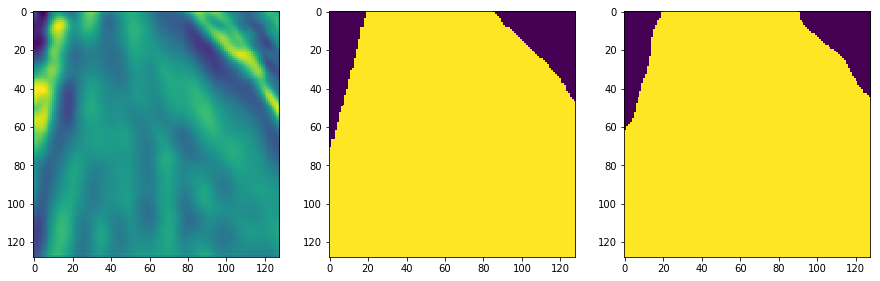

In [21]:
_id = 1218

x = load_x(_id)[0]
y = get_pred(load_y(_id))
pred = get_pred(load_pred(_id, os.path.join(VAL_PATH, 'test_predictions')))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
ax_x = axs[0]
ax_true = axs[1]
ax_pred = axs[2]

ax_x.imshow(x)
ax_true.imshow(y)
ax_pred.imshow(pred)

plt.show()

In [45]:
dices_path = os.path.join(EXP_PATH,
    f'experiment_{n_val}/' + 'val_metrics/' + list(metrics_dict.keys())[0] + '.json'
)

dices_dict = load_json(dices_path)

print('average test dice is', np.mean(list(dices_dict.values())))

average test dice is 0.34392889253847364


In [46]:
dices_dict

{'1033': 0.15268743580965422,
 '1048': 0.9115404168784952,
 '1062': 0.10063942174033917,
 '1131': 0.5572542269920017,
 '1147': 0.0,
 '1168': 0.9257724957555178,
 '1184': 0.9007603041216486,
 '1235': 0.5087001023541453,
 '1289': 0.9627911666834729,
 '1341': 0.0,
 '1377': 0.0,
 '1400': 0.0,
 '1457': 0.9790086434997354,
 '1471': 0.9773962353311806,
 '1481': 0.4249113125739062,
 '1499': 0.0,
 '1508': 0.7134193016545958,
 '155': 0.9425385934819898,
 '1566': 0.4294043338839763,
 '1622': 0.0,
 '1863': 0.0,
 '1878': 0.5242833218402128,
 '1975': 0.0,
 '2010': 0.0,
 '2114': 0.7219837863614688,
 '2147': 0.0,
 '2165': 0.32718288387741157,
 '2205': 0.0,
 '2240': 0.2884573423521711,
 '2258': 0.9194004695118281,
 '2311': 0.06890232728605461,
 '2314': 0.0012021638950110197,
 '234': 0.5319701395650763,
 '238': 0.4593709383935534,
 '2391': 0.0,
 '2416': 0.8564708581918311,
 '2437': 0.027962411184964474,
 '2446': 0.0,
 '2481': 0.0,
 '2514': 0.21554507077228707,
 '2533': 0.521078792341679,
 '262': 0.0,
 '

In [55]:
x = load_x(2)
x2 = load_x(3)

In [ ]:
model_torch.model()

In [56]:
model_torch.do_inf_step([x, x2])

array([[[[-3.178863  , -3.9236875 , -3.5634425 , ...,  2.772264  ,
           2.4374335 ,  0.98378295],
         [-3.9473615 , -4.067945  , -3.746395  , ...,  4.3426995 ,
           4.1710725 ,  2.4934452 ],
         [-4.0616827 , -4.2716136 , -4.0176544 , ...,  4.5947924 ,
           4.356154  ,  2.7890475 ],
         ...,
         [ 2.4954967 ,  3.7721095 ,  3.7745438 , ...,  3.1943607 ,
           3.2642066 ,  2.1575618 ],
         [ 2.2979748 ,  3.7047505 ,  3.6760526 , ...,  3.224391  ,
           3.2195652 ,  1.9648759 ],
         [ 0.91565627,  2.167159  ,  2.4441078 , ...,  2.1755984 ,
           1.9171755 ,  0.70111865]]],


       [[[-3.1519425 , -4.0652    , -3.798467  , ..., -4.1159954 ,
          -4.210542  , -3.345875  ],
         [-3.7085564 , -3.774377  , -3.7966733 , ..., -4.12751   ,
          -3.9616835 , -4.1194954 ],
         [-3.634927  , -3.7550442 , -3.8125658 , ..., -4.273037  ,
          -4.11304   , -4.083414  ],
         ...,
         [ 1.7270644 ,  2.367951

### val 1

In [13]:
n_val = 1
VAL_PATH = os.path.join(EXP_PATH, f'experiment_{n_val}')

In [15]:
x_train, y_train, x_val, y_val, x_test, y_test = load_experiment_data(exp_path=EXP_PATH, n_val=n_val)
val_data = (x_val, y_val)

train_ids = cv_splits[n_val]['train_ids']

batch_iter = BatchIter(train_ids=train_ids, load_x=load_x, load_y=load_y,
                       batch_size=batch_size)

In [16]:
model = get_UNet(n_channels=n_channels, n_classes=n_classes)
model_torch = TorchModel(model=model, loss_fn=loss_fn, metric_fn=metric_fn,
                         optim=optim, lr_scheduler=lr_scheduler)

model_filename = os.path.join(VAL_PATH, 'model.pt')
torch.save(model_torch.model, model_filename)

make_predictions(exp_path=EXP_PATH, n_val=n_val, model=model_torch)

calculate_metrics(exp_path=EXP_PATH, n_val=n_val, metrics_dict=metrics_dict)

In [17]:
from saltsegm.utils import load_json

dices_path = os.path.join(EXP_PATH,
    f'experiment_{n_val}/' + 'test_metrics/' + list(metrics_dict.keys())[0] + '.json'
)

dices_dict = load_json(dices_path)

print('average test dice is', np.mean(list(dices_dict.values())))

average test dice is 0.2700747126525876


### val 2

In [18]:
n_val = 2
VAL_PATH = os.path.join(EXP_PATH, f'experiment_{n_val}')

In [19]:
x_train, y_train, x_val, y_val, x_test, y_test = load_experiment_data(exp_path=EXP_PATH, n_val=n_val)
val_data = (x_val, y_val)

train_ids = cv_splits[n_val]['train_ids']

batch_iter = BatchIter(train_ids=train_ids, load_x=load_x, load_y=load_y,
                       augm_fn=augm_example, batch_size=batch_size)

In [20]:
model_torch = TorchModel(model=model, loss_fn=loss_fn, metric_fn=metric_fn,
                         optim=optim, lr=1e-2)
model = get_UNet(n_channels=n_channels, n_classes=n_classes)

history = model_torch.fit_generator(
    batch_iter.flow(), epochs=20, val_data=val_data,
    steps_per_epoch=steps_per_epoch, verbose=True
)

model_filename = os.path.join(VAL_PATH, 'model.pt')
torch.save(model_torch.model, model_filename)

make_predictions(exp_path=EXP_PATH, n_val=n_val, model=model_torch)

calculate_metrics(exp_path=EXP_PATH, n_val=n_val, metrics_dict=metrics_dict)

epoch 1/20: 101it [00:40,  2.31it/s, val_loss=0.27952573, val_metric=0.628]                         
epoch 2/20: 101it [00:40,  2.31it/s, val_loss=0.254722, val_metric=0.672]                         
epoch 3/20: 101it [00:40,  2.33it/s, val_loss=0.22239712, val_metric=0.732]                         
epoch 4/20: 101it [00:40,  2.32it/s, val_loss=0.2846527, val_metric=0.651]                         
epoch 5/20: 101it [00:40,  2.33it/s, val_loss=0.19169465, val_metric=0.778]                         
epoch 6/20: 101it [00:40,  2.30it/s, val_loss=0.18292148, val_metric=0.744]                         
epoch 7/20: 101it [00:40,  2.31it/s, val_loss=0.22553882, val_metric=0.718]                         
epoch 8/20: 101it [00:40,  2.33it/s, val_loss=0.16543892, val_metric=0.791]                         
epoch 9/20: 101it [00:40,  2.29it/s, val_loss=0.17447554, val_metric=0.78]                         
epoch 10/20: 101it [00:40,  2.32it/s, val_loss=0.19678517, val_metric=0.758]                   

In [21]:
from saltsegm.utils import load_json

dices_path = os.path.join(EXP_PATH,
    f'experiment_{n_val}/' + 'test_metrics/' + list(metrics_dict.keys())[0] + '.json'
)

dices_dict = load_json(dices_path)

print('average test dice is', np.mean(list(dices_dict.values())))

average test dice is 0.3478203488538781
